In [1]:
import os
import glob
import numpy as np
import pandas as pd
import requests
import time
from datetime import datetime, date, time, timedelta

#for models
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score,mean_absolute_percentage_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL
from pmdarima.arima import auto_arima


#for PCA & PLS
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

#for Data
import yfinance as yf

#for Data Distribution
from scipy.stats import kurtosis, skew, shapiro
from scipy import stats

# for visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import plotly.graph_objects as go
import seaborn as sns


In [2]:
# Fetch historical data for the S&P 500
sp500_data = yf.download('^GSPC', start='2002-01-01', end='2024-01-01')

[*********************100%%**********************]  1 of 1 completed


In [3]:
print(sp500_data.head())
print(len(sp500_data)) # Print the first few rows of the data

                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2002-01-02  1148.079956  1154.670044  1136.229980  1154.670044  1154.670044   
2002-01-03  1154.670044  1165.270020  1154.010010  1165.270020  1165.270020   
2002-01-04  1165.270020  1176.550049  1163.420044  1172.510010  1172.510010   
2002-01-07  1172.510010  1176.969971  1163.550049  1164.890015  1164.890015   
2002-01-08  1164.890015  1167.599976  1157.459961  1160.709961  1160.709961   

                Volume  
Date                    
2002-01-02  1171000000  
2002-01-03  1398900000  
2002-01-04  1513000000  
2002-01-07  1308300000  
2002-01-08  1258800000  
5537


Check NA Values

In [4]:
# Check for NaN values in the data
nan_values_df = sp500_data.isna().any()

print("NaN values in DataFrame:")
print(nan_values_df)

NaN values in DataFrame:
Open         False
High         False
Low          False
Close        False
Adj Close    False
Volume       False
dtype: bool


In [5]:
#Simple Moving Average:
#returns the dataframe with additional coumn of simple moving average
def calculate_sma(df: pd.DataFrame, column: str = 'Adj Close', window_size: int = 15) -> pd.DataFrame:
    """
    Calculate the Simple Moving Average (SMA) for a given column in a DataFrame.

    Parameters:
        df (pd.DataFrame): DataFrame containing the financial data.
        column (str): Name of the column for which to calculate SMA. Default is 'close'.
        window_size (int): Size of the moving window. Default is 15.

    Returns:
        pd.DataFrame: DataFrame with SMA column added.
    """
    # Calculate SMA
    sma = df[column].rolling(window=window_size, min_periods=1).mean()
    
    # Create a DataFrame to store SMA
    df['SMA'] = sma
    df['SMA_signal'] = df['Close'] - df['SMA']
    return df

In [6]:
#Weighted Moving Average
def calculate_wma(df: pd.DataFrame, column: str = 'Adj Close', window_size: int = 15) -> pd.DataFrame:
    """
    Calculate the Weighted Moving Average (WMA) for a given column in a DataFrame.

    Parameters:
        df (pd.DataFrame): DataFrame containing the financial data.
        column (str): Name of the column for which to calculate WMA. Default is 'close'.
        window_size (int): Size of the moving window. Default is 15.

    Returns:
        pd.DataFrame: DataFrame with WMA and WMA signal columns added.
    """
    # Generate the weights
    weights = np.arange(1, window_size + 1)
    data = df[column]
    
    # Calculate the WMA using convolution
    wma = data.rolling(window=window_size).apply(lambda prices: np.dot(prices, weights) / weights.sum(), raw=True)
    
    # Create a DataFrame to store WMA
    df['WMA'] = wma
    
    # Add WMA signal column
    df['WMA_signal'] = df[column] - wma

    
    return df

In [7]:
#MACD
def calculate_macd(df: pd.DataFrame, short_window:int=12, long_window:int=26, signal_window:int=9, column: str = 'Adj Close') -> pd.DataFrame:
    """
    Calculate the Moving Average Convergence Divergence (MACD) for a DataFrame.

    Parameters:
        df (DataFrame): DataFrame containing the data.
        short_window (int): The short-term window size for the short EMA.
        long_window (int): The long-term window size for the long EMA.
        signal_window (int): The window size for the signal line EMA.

    Returns:
        DataFrame: DataFrame with additional columns for MACD and signal line.
    """
    # Calculate short-term EMA
    short_ema = df[column].ewm(span=short_window, min_periods=1, adjust=False).mean()
    
    # Calculate long-term EMA
    long_ema = df[column].ewm(span=long_window, min_periods=1, adjust=False).mean()
    
    # Calculate MACD line
    macd_line = short_ema - long_ema
    
    # Calculate signal line
    signal_line = macd_line.ewm(span=signal_window, min_periods=1, adjust=False).mean()
    
    # Store MACD and signal line in the DataFrame
    df['MACD'] = macd_line
    df['Signal Line'] = signal_line
    df['macd_signal'] = macd_line - signal_line
    return df

In [8]:
#Stochastic_oscillator
def calculate_stochastic_oscillator(df, k_fast_period=14, k_slow_period=3, d_slow_period=3, column: str = 'Adj Close'):
    """
    Calculate the Stochastic Oscillator and its corresponding moving averages (K and D lines).

    Parameters:
        df (DataFrame): DataFrame containing the data.
        k_fast_period (int): The period for the fast %K line.
        k_slow_period (int): The period for the slow %K line.
        d_slow_period (int): The period for the slow %D line.

    Returns:
        DataFrame: DataFrame with additional columns for %K_fast, %K_slow, %D_fast, and %D_slow.
    """
    # Calculate highest high and lowest low over the period
    HH = df['High'].rolling(window=k_fast_period).max()
    LL = df['Low'].rolling(window=k_fast_period).min()

    # Calculate %K_fast
    df['%K_fast'] = ((df[column] - LL) / 
                     (HH - LL)) * 100
    
    # Calculate %K_slow (smoothed %K_fast)
    df['%K_slow'] = df['%K_fast'].rolling(window=k_slow_period).mean()
    
    # Calculate %D_fast (3-day SMA of %K_slow)
    df['%D_fast'] = df['%K_slow'].rolling(window=d_slow_period).mean()
    
    # Calculate %D_slow (3-day SMA of %D_fast)
    df['%D_slow'] = df['%D_fast'].rolling(window=d_slow_period).mean()
    
    return df

In [9]:
#RSI
def calculate_rsi(df, window_size=14, column: str = 'Adj Close'):
    """
    Calculate the Relative Strength Index (RSI) for a DataFrame.

    Parameters:
        df (DataFrame): DataFrame containing the data.
        window (int): The window size for calculating RSI.

    Returns:
        DataFrame: DataFrame with an additional column for RSI.
    """
    # Calculate price changes
    delta = df[column].diff()
    
    # Define up and down moves
    gain = (delta.where(delta > 0, 0)).rolling(window=window_size).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window_size).mean()
    
    # Calculate the relative strength (RS)
    rs = gain / loss
    
    # Calculate RSI
    rsi = 100 - (100 / (1 + rs))
    
    # Store RSI in the DataFrame
    df['RSI'] = rsi
    
    return df

In [10]:
#WPR
def calculate_williams_percent_r(df, window=14, column: str = 'Adj Close'):
    """
    Calculate the Williams %R (WPR) for a DataFrame.

    Parameters:
        df (DataFrame): DataFrame containing the data.
        window (int): The window size for calculating WPR.

    Returns:
        DataFrame: DataFrame with an additional column for WPR.
    """
    # Calculate highest high and lowest low over the window
    highest_high = df['High'].rolling(window=window).max()
    lowest_low = df['Low'].rolling(window=window).min()
    
    # Calculate Williams %R
    wpr = ((highest_high - df[column]) / (highest_high - lowest_low)) * -100
    
    # Store WPR in the DataFrame
    df['WPR'] = wpr
    
    return df

In [11]:
#Bollinger Bands
def calculate_bollinger_bands(df, window=20, num_std_dev=2, column: str = 'Adj Close'):
    """
    Calculate Bollinger Bands for a DataFrame.

    Parameters:
        df (DataFrame): DataFrame containing the data.
        window (int): The window size for the moving average.
        num_std_dev (int): The number of standard deviations for the bands.

    Returns:
        DataFrame: DataFrame with additional columns for Bollinger Bands.
    """
    # Calculate rolling mean and standard deviation
    rolling_mean = df[column].rolling(window=window).mean()
    rolling_std = df[column].rolling(window=window).std()
    
    # Calculate upper and lower bands
    upper_band = rolling_mean + (rolling_std * num_std_dev)
    lower_band = rolling_mean - (rolling_std * num_std_dev)
    
    # Store Bollinger Bands in the DataFrame
    df['Bollinger Upper'] = upper_band
    df['Bollinger Lower'] = lower_band
    df['Bollinger Diff'] = upper_band - lower_band
    
    return df

In [12]:
#On-Balance Volume (OBV)
def calculate_obv(df, column: str = 'Adj Close'):
    """
    Calculate On-Balance Volume (OBV) for a DataFrame.

    Parameters:
        df (DataFrame): DataFrame containing the data.

    Returns:
        DataFrame: DataFrame with additional column for OBV.
    """
    obv_values = []
    prev_obv = 0

    for i in range(1, len(df)):
        if df[column].iloc[i] > df[column].iloc[i - 1]:
            obv = prev_obv + df['Volume'].iloc[i]
        elif df[column].iloc[i] < df[column].iloc[i - 1]:
            obv = prev_obv - df['Volume'].iloc[i]
        else:
            obv = prev_obv

        obv_values.append(obv)
        prev_obv = obv

    # Add initial OBV value as 0
    obv_values = [0] + obv_values

    # Store OBV in the DataFrame
    df['OBV'] = obv_values

    return df

In [13]:
#Average True Range (ATR)
def calculate_atr(df, period=14):
    """
    Calculate the Average True Range (ATR) of a stock dataset.

    Parameters:
        df (DataFrame): DataFrame containing stock data, with 'High', 'Low', and 'Close' columns representing high, low, and closing prices respectively.
        period (int): Number of periods for which to calculate the ATR (default is 14).

    Returns:
        DataFrame: DataFrame with 'ATR' column containing the calculated ATR values.
    """
    high = df['High']
    low = df['Low']
    close = df['Adj Close']
    
    # True Range (TR) calculation
    df['TR'] = df[['High', 'Low', 'Adj Close']].apply(lambda row: max(row['High'] - row['Low'], abs(row['High'] - row['Adj Close']), abs(row['Low'] - row['Adj Close'])), axis=1)
    
    # ATR calculation
    df['ATR'] = df['TR'].rolling(period).mean()
    
    # Drop the TR column if not needed
    df.drop('TR', axis=1, inplace=True)
    
    return df

In [14]:
#rice Rate of Change (ROC)
def calculate_roc(df, n_periods=12, column='Adj Close'):
    """
    Calculate the Price Rate of Change (ROC) of a stock dataset.

    Parameters:
        df (DataFrame): DataFrame containing stock data, with 'Adj Close' column representing closing prices.
        n_periods (int): Number of periods for which to calculate the ROC. # It can be anything such as 12, 25,
        or 200. Short-term trader traders typically use a smaller number while longer-term investors use a larger
        number.

    Returns:
        DataFrame: DataFrame with 'ROC' column containing the calculated ROC values.
    """
    close_prices = df[column]
    close_prices_shifted = close_prices.shift(n_periods)
    
    roc = ((close_prices - close_prices_shifted) / close_prices_shifted) * 100
    
    df['ROC'] = roc
    return df

In [15]:
#Money Flow Index - MFI
def calculate_mfi(df, period=14):
    """
    Calculate the Money Flow Index (MFI) of a stock dataset.

    Parameters:
        df (DataFrame): DataFrame containing stock data, with 'High', 'Low', 'Close', and 'Volume' columns representing high, low, closing prices, and volume respectively.
        period (int): Number of periods for which to calculate the MFI (default is 14).

    Returns:
        DataFrame: DataFrame with 'MFI' column containing the calculated MFI values.
    """
    high = df['High']
    low = df['Low']
    close = df['Adj Close']
    volume = df['Volume']
    
    # Typical Price calculation
    tp = (high + low + close) / 3
    
    # Raw Money Flow calculation
    mf = tp * volume
    
    # Determine whether the typical price is higher or lower than the previous period
    tp_shifted = tp.shift(1)
    positive_flow = (tp > tp_shifted)
    negative_flow = (tp < tp_shifted)
    
    # Calculate positive and negative money flow
    positive_mf = positive_flow * mf
    negative_mf = negative_flow * mf
    
    # Calculate the Money Flow Ratio (MFR)
    mfr = positive_mf.rolling(window=period).sum() / negative_mf.rolling(window=period).sum()
    
    # Calculate the Money Flow Index (MFI)
    mfi = 100 - (100 / (1 + mfr))
    
    df['MFI'] = mfi
    
    return df

In [16]:
#chaikin_oscillator
def calculate_chaikin_oscillator(df, short_period=3, long_period=10):
    """
    Calculate the Chaikin Oscillator of a stock dataset.

    Parameters:
        df (DataFrame): DataFrame containing stock data, with 'High', 'Low', 'Adj Close', and 'Volume' columns representing high, low, closing prices, and volume respectively.
        short_period (int): Number of periods for the short EMA (default is 3).
        long_period (int): Number of periods for the long EMA (default is 10).

    Returns:
        DataFrame: DataFrame with 'Chaikin_Oscillator' column containing the calculated Chaikin Oscillator values.
    """
    high = df['High']
    low = df['Low']
    close = df['Adj Close']
    volume = df['Volume']
    
    # Money Flow Multiplier calculation
    mfm = ((close - low) - (high - close)) / (high - low)
    
    # Money Flow Volume calculation
    mfv = mfm * volume
    
    # Accumulation/Distribution Line (ADL) calculation
    adl = mfv.cumsum()
    
    # Calculate the EMA for ADL
    ema_short = adl.ewm(span=short_period, min_periods=short_period, adjust=False).mean()
    ema_long = adl.ewm(span=long_period, min_periods=long_period, adjust=False).mean()
    
    # Calculate the Chaikin Oscillator
    chaikin_oscillator = ema_short - ema_long
    
    df['Chaikin_Oscillator'] = chaikin_oscillator
    
    return df

In [17]:
#Bulid the technical indicators: features
def technical_indicators(df):
    df = calculate_sma(df)
    df = calculate_wma(df)
    df = calculate_macd(df)
    df = calculate_rsi(df)
    df = calculate_stochastic_oscillator(df)
    df = calculate_bollinger_bands(df)
    df = calculate_williams_percent_r(df)
    df = calculate_obv(df)
    df = calculate_roc(df)
    df = calculate_atr(df)
    df = calculate_mfi(df)
    df = calculate_chaikin_oscillator(df)
    return df  

In [18]:
# All analyzed technical indicators are lagged by one period before being used as predictors for returns in the models in order to avoid the so-called look ahead 
# bias involving making decisions in the same period for which the given signal was generated.
def lag_technical_indicators(df):
    """
    Lag all columns in a DataFrame by one period.

    Parameters:
        df (DataFrame): DataFrame containing the calculated technical indicators.

    Returns:
        DataFrame: DataFrame with all columns lagged by one period.
    """
    # Lag all columns by one period
    df_lagged = df.shift()
    
    return df_lagged

In [19]:
# Transformation Function
# Technical analysis indicators need to be rescaled before being fed to the models.
# The process is conducted using a version of min-max normalization technique which produces outputs in range from ‐1 to 1.
# This technique was chosen for two reasons: it is intuitive as the machine learning models produce output 
# variable that is also ranging from ‐1 to 1 and because it causes the input data to be more comparable. 
# X'(t) = (X(t) - min(x)) / (max(x) - min(x))*2 -1

def feature_transform(df):
    """
    Transform all columns in the DataFrame as the following formula
    X'(t) = (X(t) - min(x)) / (max(x) - min(x))*2 -1

    Parameters:
        df (DataFrame): DataFrame containing the calculated technical indicators.

    Returns:
        DataFrame: DataFrame with all columns transformed.
    """
    max_x = df.max()
    min_x = df.min()

    df_transformed = (df - min_x) / (max_x - min_x) * 2 - 1

    return df_transformed

In [20]:
#truncate the dataframe from the biggining so the walk forward splits will continue untill the last date
def truncate_before_wf(df, in_sample_size, out_sample_size):
    drop_index = (len(df) - in_sample_size) % out_sample_size
    return (df.iloc[drop_index:, :])

In [21]:
# Research employed dynamic estimation windows which means that the underlying parameters of the models 
# were periodically recalibrated to reflect current market behaviors. Observations from the beginning 
# of the available period were initially trimmed in order for the overall number of observations for
# each index to be easily divisible into equal subsets. Calibration of models’ parameters was conducted 
# on 200 trading day window (in-sample) and then model predictions were applied onto next 20 trading day
# window (out-of-sample). For each subsequent dynamic window iteration, in-sample and out-of-sample moved 
# by 20 trading days. 

def walk_forward_validation(df, in_sample_size, out_sample_size):
    """
    Perform walk-forward validation on a DataFrame.

    Parameters:
        df (DataFrame): DataFrame containing the data.
        in_sample_size (int): Number of periods to use for in-sample data.
        out_sample_size (int): Number of periods to use for out-of-sample data.

    Returns:
        Tuple: Tuple containing lists of in-sample and out-of-sample data.
    """
    total_rows = len(df)
    n_subsets = (total_rows - in_sample_size) // out_sample_size
    splits = []
        
    for i in range(n_subsets):
        start_index = i * out_sample_size
        end_index = start_index + in_sample_size + out_sample_size
        
        if end_index > total_rows:
            break
        
        in_sample = df.iloc[start_index : start_index + in_sample_size]
        out_of_sample = df.iloc[start_index + in_sample_size : end_index]
        
        splits.append((in_sample, out_of_sample))
    return (splits)

In [22]:
# Compute the correlation coefficients between each feature and the return & print it

def correlation(df, target_name):

    correlation_with_target = np.abs(df.corrwith(df[target_name]))

    # Display the correlation coefficients
    print("Correlation with Log return:")
    print(correlation_with_target.sort_values(ascending=False))
    correlation_with_target.sort_values().plot.barh(color = 'blue',title = 'Strength of Correlation', )

In [23]:
#Thus far, we've only used a simple correlation statistic across the full time period. 
#This is a good place to start but, is a dangerous place to stop. Financial time series data suffers
# from non-stationarity and regime change, so a relationship which on average has existed may have been 
#wildly unstable over time.

#To check, we'll plot the rolling correlation of these selected features.

# Compute the rolling correlation for each pair of selected features
def rolling_correlation(df, target_name, window_size = 200):

    correlation_with_target_200 = df.rolling(window=window_size).corr(df[target_name])
    # Create traces for each feature
    traces = []
    for feature in df.columns:
        trace = go.Scatter(
            x=correlation_with_target_200.index,
            y=correlation_with_target_200[feature],
            mode='lines',
            name=feature
        )
        traces.append(trace)

    # Create layout for the plot
        layout = go.Layout(
        title='Rolling Correlation of Features with Log Return',
        xaxis=dict(title='Index'),
        yaxis=dict(title='Rolling Correlation with Log Return'),
        hovermode='closest',
        autosize=True
    )

    # Create figure object
    fig = go.Figure(data=traces, layout=layout)

    # Show plot
    fig.show()

In [24]:
#Pair plot
def features_paiplot(df):
    pairplot = sns.pairplot(df, height=1.5)

    # Set the title
    pairplot.figure.suptitle('Pairplot of features', y=1.02)

    # Show the plot
    plt.show()

In [25]:
def count_outliers_iqr_df(df, k=1.5):
    """
    Count the number of outliers in each column of the DataFrame using the Interquartile Range (IQR) method.
    
    Parameters:
    - df: The input DataFrame.
    - k: The multiplier for the IQR. Typically set to 1.5 to 3.
    
    Returns:
    - A dictionary where keys are column names and values are the number of outliers detected in each column.
    """
    outliers_counts = {}
    for col in df.columns:
        data = df[col]
        quartile_1, quartile_3 = np.percentile(data, [25, 75])
        iqr = quartile_3 - quartile_1
        lower_bound = quartile_1 - (k * iqr)
        upper_bound = quartile_3 + (k * iqr)
        outliers = (data < lower_bound) | (data > upper_bound)
        outliers_counts[col] = np.sum(outliers)
    return outliers_counts


In [26]:
#Truncate NaN Data
def drop_nan(df):
    # Remove rows with NaN values
    cleaned_df = df.dropna()

    return cleaned_df

In [27]:
#check distribution 
def check_distribution(df, column_name='Adj Close'):
    """
    Check the distribution of a column in a DataFrame.

    Parameters:
        df (DataFrame): DataFrame containing the data.
        column_name (str): Name of the column to check the distribution for (default is 'Adj Close').

    Returns:
        None (displays descriptive statistics and visualizations)
    """
    # Descriptive statistics
    print("Descriptive Statistics:")
    print(df[column_name].describe())

    # Histogram
    plt.figure(figsize=(10, 6))
    sns.histplot(df[column_name], kde=True)
    plt.title(f'Distribution of {column_name}')
    plt.xlabel(column_name)
    plt.ylabel('Frequency')
    plt.show()

In [28]:
def is_normal(df, alpha=0.05):
    """
    Test if the data is normally distributed using Z-score.
    
    Parameters:
    - data: The input data array.
    - alpha: The significance level for the test.
    
    Returns:
    - True if the data is normally distributed, False otherwise.
    """
    normal_col = {}
    for col in df.columns:
        data = df[col]
        z_score, p_value = stats.normaltest(data)
        normal_col[col] = p_value > alpha
    return normal_col

Models Evaluation

In [29]:
def calculate_mape(actual, predicted):
    """
    Calculate Mean Absolute Percentage Error (MAPE)
    
    Args:
    actual: array-like, actual values
    predicted: array-like, predicted values
    
    Returns:
    mape: float, MAPE value
    """
    # Ensure both actual and predicted arrays have the same length
    if len(actual) != len(predicted):
        raise ValueError("Length of actual and predicted arrays must be the same.")
    

    # Calculate absolute percentage error for each observation
    abs_percentage_error = np.abs((actual - predicted) / np.maximum(np.abs(actual), 1e-10))
    
    # Calculate mean of absolute percentage errors
    mape = np.mean(abs_percentage_error) * 100
    
    return mape

In [30]:
## start from here

In [31]:
#try 
sp500 = sp500_data.copy()
sp500 = technical_indicators(sp500)

In [32]:
#laging technical indicators to avoid look_ahead bias
#sp500.iloc[:, 6:] = sp500.iloc[:, 6:].apply(lag_technical_indicators, axis=0)

In [33]:
#transform features
sp500.iloc[:, 6:] = sp500.iloc[:, 6:].apply(feature_transform, axis=0)

C:\Users\Nagham\AppData\Local\Temp\ipykernel_20340\3326783675.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Date
2002-01-02   -0.934138
2002-01-03   -0.932189
2002-01-04   -0.930082
2002-01-07   -0.931904
2002-01-08   -0.933658
                ...   
2023-12-22    0.859675
2023-12-26    0.863177
2023-12-27    0.867006
2023-12-28    0.870766
2023-12-29    0.866411
Name: OBV, Length: 5537, dtype: float64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  sp500.iloc[:, 6:] = sp500.iloc[:, 6:].apply(feature_transform, axis=0)


In [34]:
#correlation before choosing features
#correlation(sp500, 'Adj Close')
#rolling_correlation(sp500, 'Adj Close')

# Step 1: Take the most strongly correlated feature and add it to our list of selected features. 
# Step 2: Take the second correlated feature and check to see if it's closely correlated 
# (neighboring in the clustermap) to any features already chosen.
# If no, add to the list. If yes, discard. 
# Step 3: Repeat this process until either (1) we've reached the target feature count, or (2) we've run out strongly correlated features.

In [35]:
# start here

In [58]:
#clean the data from na values & pick the columns
sp500_d = sp500.copy()
sp500_d = drop_nan(sp500_d)
sp500_d = sp500_d.loc[:, ['SMA','WMA', 'MACD', 'RSI', '%K_fast', '%D_fast', '%D_slow', 'Bollinger Diff',
                    'WPR', 'OBV', 'ROC', 'ATR', 'MFI', 'Chaikin_Oscillator', 'Adj Close']]

Descriptive Statistics:
count    5517.000000
mean     2036.598106
std      1088.442367
min       676.530029
25%      1194.439941
50%      1531.020020
75%      2713.060059
max      4796.560059
Name: Adj Close, dtype: float64


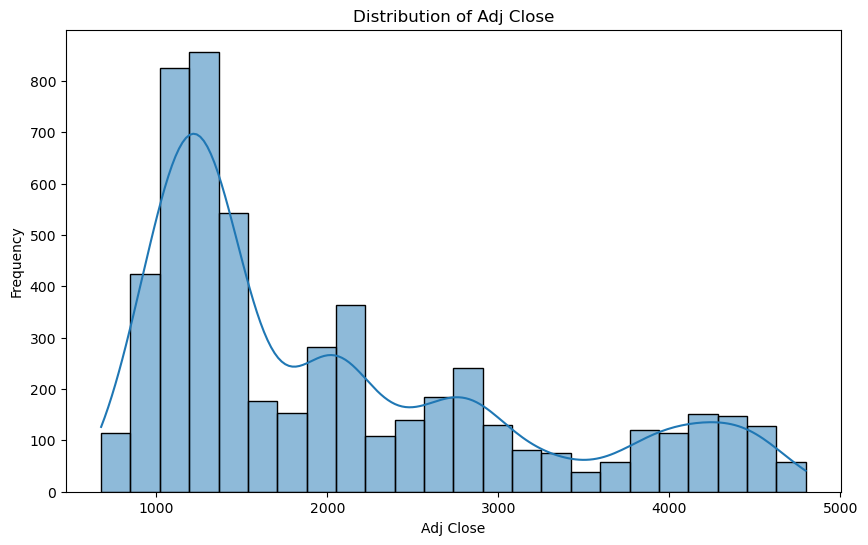

In [37]:
check_distribution(sp500_d)

In [38]:
#look at the correlated data:
#features_paiplot(sp500_d)
#correlation(sp500_d, 'Adj Close')
#rolling_correlation(sp500, 'Adj Close')


In [39]:
print("Is data normal?", is_normal(sp500_d))

Is data normal? {'SMA': False, 'WMA': False, 'MACD': False, 'RSI': False, '%K_fast': False, '%D_fast': False, '%D_slow': False, 'Bollinger Diff': False, 'WPR': False, 'OBV': False, 'ROC': False, 'ATR': False, 'MFI': False, 'Chaikin_Oscillator': False, 'Adj Close': False}


In [40]:
outliers_counts = count_outliers_iqr_df(sp500_d)
print("Number of outliers in each column:")
print(outliers_counts)

Number of outliers in each column:
{'SMA': 0, 'WMA': 0, 'MACD': 482, 'RSI': 2, '%K_fast': 0, '%D_fast': 0, '%D_slow': 0, 'Bollinger Diff': 476, 'WPR': 0, 'OBV': 0, 'ROC': 260, 'ATR': 453, 'MFI': 8, 'Chaikin_Oscillator': 63, 'Adj Close': 0}


In [41]:
#choosing features:
chosen_features = ['SMA','WMA', 'MACD', 'RSI', '%K_fast', '%D_fast', '%D_slow', 'Bollinger Diff',
                    'WPR', 'OBV', 'ROC', 'ATR', 'MFI', 'Chaikin_Oscillator', 'Adj Close']


Linear SVR

In [59]:
#Model - Linear SVR
#Split the data
sp500_d = truncate_before_wf(sp500_d, 200, 20)
splits = walk_forward_validation(sp500_d, 200, 20)
Linear_SVR = SVR(C=10000, kernel='linear')

In [43]:
# In the context of regression tasks like this one (since SVR is a Support Vector Machine for regression),
# where the target variable is continuous (e.g., log returns), a model score less than 0 typically indicates 
# that the model is performing poorly and making predictions that are worse than simply using the mean or another
# basic statistical measure as the prediction for all samples.

Mean Absolute Percentage Error (MAPE): 1.0678316640863126
Model Score: 0.13476157227172672
Mean Absolute Error: 21.637715436538876
Mean Squared Error: 1298.2237346987608
Root Mean Squared Error: 36.030871966950244
R-squared: 0.9989049781803474


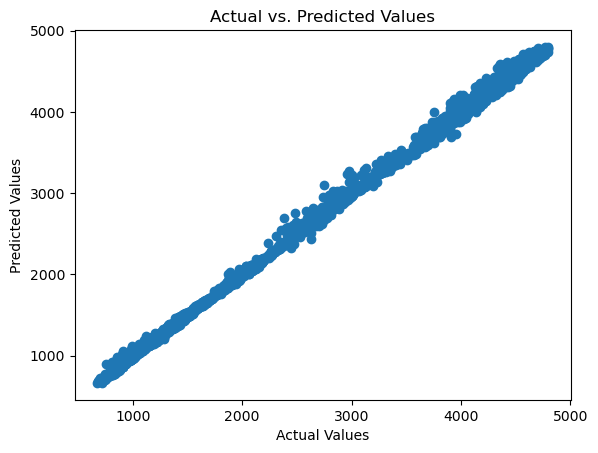

In [60]:
#train the model

# Initialize an empty list to store predictions
sp500_d['Predections_LinearSVM'] = np.nan

score = 0
# Loop through the splits and make predictions for each iteration
for i, (in_sample, out_of_sample) in enumerate(splits):
    #Train the model on in_sample data
    X_train = in_sample.drop(columns=['Adj Close']) # dropping target variable
    y_train = in_sample['Adj Close']
    Linear_SVR.fit(X_train,y_train)

    # Make predictions on the out-of-sample data
    X_test = out_of_sample.drop(columns=['Adj Close'])
    y_test = out_of_sample['Adj Close']
    predictions = Linear_SVR.predict(X_test)

    #model score
    score += Linear_SVR.score(X_test, y_test)

    # Out of Sample Index
    oosI = out_of_sample.index # Adjusted index to match shifted returns

    #Add predictions to df
    sp500_d.loc[oosI, 'Predections_LinearSVM']  = predictions

sp500_d = drop_nan(sp500_d)

# 4. Evaluation Metrics
score = score/len(splits)
mae = mean_absolute_error(sp500_d['Adj Close'], sp500_d['Predections_LinearSVM'])
mse = mean_squared_error(sp500_d['Adj Close'], sp500_d['Predections_LinearSVM'])
rmse = np.sqrt(mse)
r2 = r2_score(sp500_d['Adj Close'], sp500_d['Predections_LinearSVM'])
mape = calculate_mape(sp500_d['Adj Close'], sp500_d['Predections_LinearSVM'])

print("Mean Absolute Percentage Error (MAPE):", mape)
print("Model Score:", score)
print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R-squared:", r2)

# Visualize predictions vs. actual values
plt.scatter(sp500_d['Adj Close'], sp500_d['Predections_LinearSVM'])
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")
plt.show()

In [61]:
# Assuming df is your DataFrame containing the data
# Replace 'feature1' and 'feature2' with the names of the features you want to plot
feature1 = 'Adj Close'
feature2 = 'Predections_LinearSVM'

# Create line plot
fig = go.Figure(data=go.Scatter(
    x=sp500_d.index,  # Assuming the index represents x-axis values
    y=sp500_d[feature1],
    mode='lines',
    name=feature1
))

# Add another line plot for the second feature
fig.add_trace(go.Scatter(
    x=sp500_d.index,  # Assuming the index represents x-axis values
    y=sp500_d[feature2],
    mode='lines',
    name=feature2
))

# Customize layout
fig.update_layout(
    title='Linear SVR - Adj Close Vs. Predictions on train dataset - WF 200,20',
    xaxis=dict(title='X Axis'),  # Customize x-axis label
    yaxis=dict(title='Y Axis'),  # Customize y-axis label
    hovermode='closest'
)

# Show plot
fig.show()


Arima Model without Time Sieries Decomposition

In [ ]:
#clean the data from na values & pick the columns
data = sp500.copy()
data = drop_nan(data)
data = data.loc[:, ['SMA','WMA', 'MACD', 'RSI', '%K_fast', '%D_fast', '%D_slow', 'Bollinger Diff',
                    'WPR', 'OBV', 'ROC', 'ATR', 'MFI', 'Chaikin_Oscillator', 'Adj Close']]

In [ ]:
# Auto ARIMA to select optimal ARIMA parameters
model = auto_arima(data['Adj Close'], seasonal=False, trace=True)
print(model.summary())

Best Arima Model is ARIMA(2,1,2)

The data Splitted 80% - 20% - Walk Forward on test (the predictions added to the train)

In [ ]:
data['Adj Close'].shift()

In [ ]:
dataset_ex_df = lag_technical_indicators(data['Adj Close']).dropna()
# Define the ARIMA model
def arima_forecast(history):
    # Fit the model
    model = ARIMA(history, order=(2,1,2))
    model_fit = model.fit()
    
    # Make the prediction
    output = model_fit.forecast()
    yhat = output[0]
    return yhat

# Split data into train and test sets
X = dataset_ex_df.values
size = int(len(X) * 0.8)
train, test = X[0:size], X[size:len(X)]

# Walk-forward validation
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    # Generate a prediction
    yhat = arima_forecast(history)
    predictions.append(yhat)
    # Add the predicted value to the training set
    obs = test[t]
    history.append(obs)

In [ ]:
dataset_ex_df.head()

In [ ]:
#return the lagged data to 
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(dataset_ex_df.iloc[size:].index, test, label='Real')
plt.plot(dataset_ex_df.iloc[size:].index, predictions, color='red', label='Predicted')
plt.title('ARIMA Predictions vs Actual Values')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [ ]:
#Evaluate
mae = mean_absolute_error(test,predictions)
mse = mean_squared_error(test,predictions)
rmse = np.sqrt(mse)
r2 = r2_score(test,predictions)
mape = mean_absolute_percentage_error(test,predictions)
# Visualize predictions vs. actual values
plt.scatter(test,predictions)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")
plt.show()

print(f'Mean Absolute Error: {mae}\nMean Squared Error: {mse}\nRoot Mean Squared Error: {rmse}\nR-squared: {r2}')
print("Mean Absolute Percentage Error (MAPE):", mape)

In [ ]:
# Plotting
# Create traces
trace1 = go.Scatter(x=dataset_ex_df.iloc[size:].index, y=test, mode='lines', name='Adjusted Close')
trace2 = go.Scatter(x=dataset_ex_df.iloc[size:].index, y=predictions, mode='lines', name='Predections')

# Create figure
fig = go.Figure()

# Add traces to figure
fig.add_trace(trace1)
fig.add_trace(trace2)

# Update layout
fig.update_layout(title='Plot of Adjuste Close Vs. Cleaned trend Data over Time',
                  xaxis_title='Time',
                  yaxis_title='USD',
                  hovermode='x unified')

# Show plot
fig.show()

Walk Forward as for the rest of models

In [ ]:
#Split the data withou WF
data = truncate_before_wf(data, 200, 20)
splits_arima = walk_forward_validation(data, 200, 20)

In [ ]:
order = (2, 1, 2)  # From Auto test
data['Predictions_Arima'] = np.nan
arima_results_list = []
all_predictions = []

for in_sample, out_of_sample in splits_arima:
    arima_model = ARIMA(in_sample['Adj Close'], order=order)
    arima_results = arima_model.fit()
    forecast = arima_results.forecast(steps=len(out_of_sample['Adj Close']))
    arima_results_list.append((arima_results, forecast))
    all_predictions.append(forecast)

# Concatenate all predictions into a single DataFrame
all_predictions_df = pd.DataFrame(np.concatenate(all_predictions), columns=['Predictions_Arima'])

# Update the 'Predictions_Arima' column in the original DataFrame
data.loc[data.index[200:], 'Predictions_Arima'] = all_predictions_df['Predictions_Arima'].values

In [ ]:
#drop Nan values from the first 200 walkforward samples(no predictions)
data = drop_nan(data)

# Visual Inspection: Actual values against the predicted values 
feature1 = 'Adj Close'
feature2 = 'Predictions_Arima'

# Create line plot
fig = go.Figure(data=go.Scatter(
    x=data.index,  # Assuming the index represents x-axis values
    y=data[feature1],
    mode='lines',
    name=feature1
))

# Add another line plot for the second feature
fig.add_trace(go.Scatter(
    x=data.index,  # Assuming the index represents x-axis values
    y=data[feature2],
    mode='lines',
    name=feature2
))

# Customize layout
fig.update_layout(
    title='Arima (2,1,2) - Adj Close Vs. Predictions on train dataset - WF 200,20',
    xaxis=dict(title='X Axis'),  # Customize x-axis label
    yaxis=dict(title='Y Axis'),  # Customize y-axis label
    hovermode='closest'
)

# Show plot
fig.show()


In [ ]:
#Evaluate

mae = mean_absolute_error(data['Adj Close'],data['Predictions_Arima'])
mse = mean_squared_error(data['Adj Close'],data['Predictions_Arima'])
rmse = np.sqrt(mse)
mape = calculate_mape(data['Adj Close'], data['Predictions_Arima'])

# Visualize predictions vs. actual values
plt.scatter(data['Adj Close'],data['Predictions_Arima'])
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")
plt.show()

print(f'Mean Absolute Error: {mae}\nMean Squared Error: {mse}\nRoot Mean Squared Error: {rmse}')
print("Mean Absolute Percentage Error (MAPE):", mape)

Arima Model with Time series decomposition

In [ ]:
row_sp500 = sp500_data.copy()

Step 1: Check for Stationarity

In [ ]:
result = adfuller(row_sp500['Adj Close'].dropna())

if (result[1] > 0.05):
    print('Data is not Stationary')
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
else:
    print('Data is Stationary')
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])

Step 2: Remove Trend

In [ ]:
row_sp500['Adj_Close_diff'] = row_sp500['Adj Close'].diff()

In [ ]:
row_sp500= row_sp500.dropna()

In [ ]:
result2 = adfuller(row_sp500['Adj_Close_diff'])

if (result2[1] > 0.05):
    print('Data is not Stationary')
    print('ADF Statistic:', result2[0])
    print('p-value:', result2[1])
else:
    print('Data is Stationary')
    print('ADF Statistic:', result2[0])
    print('p-value:', result2[1])

In [ ]:
# Plotting
# Create traces
trace1 = go.Scatter(x=row_sp500.index, y=row_sp500['Adj Close'], mode='lines', name='Adjusted Close')
trace2 = go.Scatter(x=row_sp500.index, y=row_sp500['Adj_Close_diff'], mode='lines', name='Adj_Close_diff')

# Create figure
fig = go.Figure()

# Add traces to figure
fig.add_trace(trace1)
fig.add_trace(trace2)

# Update layout
fig.update_layout(title='Plot of Adjuste Close Vs. Cleaned trend Data over Time',
                  xaxis_title='Time',
                  yaxis_title='USD',
                  hovermode='x unified')

# Show plot
fig.show()

In [ ]:
from statsmodels.tsa.stattools import acf, pacf


lags = 20  # Number of lags to consider

# Calculate ACF
acf_result = acf(row_sp500['Adj_Close_diff'], nlags=lags)

# Print ACF results
print("Autocorrelation Function (ACF):")
for lag, acf_value in enumerate(acf_result):
    print(f"Lag {lag}: {acf_value}")

# Calculate PACF
pacf_result = pacf(row_sp500['Adj_Close_diff'], nlags=lags)

# Print PACF results
print("\nPartial Autocorrelation Function (PACF):")
for lag, pacf_value in enumerate(pacf_result):
    print(f"Lag {lag}: {pacf_value}")

In [ ]:
standard_error = 1/np.sqrt(len(row_sp500))
print(standard_error)

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
sm.graphics.tsa.plot_acf(row_sp500['Adj_Close_diff'], lags=40, ax=ax[0])
sm.graphics.tsa.plot_pacf(row_sp500['Adj_Close_diff'], lags=40, ax=ax[1])
plt.show()


Scale the returns 

In [ ]:
row_sp500['Adj_Close_diff'] = feature_transform(row_sp500['Adj_Close_diff'])


Auto Arima

In [ ]:
# Auto ARIMA to select optimal ARIMA parameters
model = auto_arima(row_sp500['Adj_Close_diff'], seasonal=False, trace=True)
print(model.summary())

In [ ]:
import pmdarima as pm
auto_ar = pm.auto_arima(row_sp500['Adj_Close_diff'], stepwise=True, seasonal=False)
auto_ar

In [ ]:
auto_ar.summary()

Best Arima model is ARIMA(9,0,9) as interpretation from ACF and PACF

In [ ]:
#Split the data
arima_diff = row_sp500.copy()
adj_close_diff = truncate_before_wf(arima_diff, 200, 20)
splits_arima_diff = walk_forward_validation(adj_close_diff, 200, 20)

In [ ]:
order = (4, 0, 4)  # From Auto test
adj_close_diff['Predictions_Arima'] = np.nan
arima_results_list = []
all_predictions = []

for in_sample, out_of_sample in splits_arima_diff:
    arima_model = ARIMA(in_sample['Adj_Close_diff'], order=order)
    arima_results = arima_model.fit()
    forecast = arima_results.forecast(steps=len(out_of_sample['Adj_Close_diff']))
    arima_results_list.append((arima_results, forecast))
    all_predictions.append(forecast)

# Concatenate all predictions into a single DataFrame
all_predictions_df = pd.DataFrame(np.concatenate(all_predictions), columns=['Predictions_Arima'])

# Update the 'Predictions_Arima' column in the original DataFrame
adj_close_diff.loc[adj_close_diff.index[200:], 'Predictions_Arima'] = all_predictions_df['Predictions_Arima'].values

In [ ]:
# Assuming 'row_sp500' is your DataFrame with a time index
row_sp500.index = pd.to_datetime(row_sp500.index)  # Ensure index is datetime type

# Resample the data to the desired frequency
resampled_data = row_sp500['Adj_Close_diff'].resample('D').mean().interpolate()

# Perform STL decomposition
stl_result = STL(resampled_data).fit()

# Extract the components
trend = stl_result.trend
seasonal = stl_result.seasonal
residual = stl_result.resid

# Plot the components
plt.figure(figsize=(10, 8))

plt.subplot(411)
plt.plot(resampled_data, label='Original')
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(resampled_data.index, trend, label='Trend')
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(resampled_data.index, seasonal, label='Seasonal')
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(resampled_data.index, residual, label='Residual')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
# Subtract trend, seasonal, and residual components from the original data
detrended_data = resampled_data - trend
deseasonalized_data = resampled_data - seasonal
residual_data = resampled_data - trend - seasonal

# Plot the detrended, deseasonalized, and residual data
plt.figure(figsize=(10, 6))

plt.subplot(311)
plt.plot(detrended_data, label='Detrended Data')
plt.legend()

plt.subplot(312)
plt.plot(deseasonalized_data, label='Deseasonalized Data')
plt.legend()

plt.subplot(313)
plt.plot(residual_data, label='Residual Data')
plt.legend()

plt.tight_layout()
plt.show()

Plot Residuals 

In [ ]:
#plot residuals and density
residuals = arima_results.resid
fig, ax = plt.subplots(1,2)
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(title='Density', kind='kde', ax=ax[1])
plt.show()

In [ ]:
# Assuming df is your DataFrame containing the data
# Replace 'feature1' and 'feature2' with the names of the features you want to plot
feature1 = 'Adj_Close_diff'
feature2 = 'Predictions_Arima'

# Create line plot
fig = go.Figure(data=go.Scatter(
    x=adj_close_diff.index,  # Assuming the index represents x-axis values
    y=adj_close_diff[feature1],
    mode='lines',
    name=feature1
))

# Add another line plot for the second feature
fig.add_trace(go.Scatter(
    x=adj_close_diff.index,  # Assuming the index represents x-axis values
    y=adj_close_diff[feature2],
    mode='lines',
    name=feature2
))

# Customize layout
fig.update_layout(
    title='Arima Model (4,0,4) - Adj Close Diff Transformed Vs. Predictions on train dataset - WF 200,20',
    xaxis=dict(title='X Axis'),  # Customize x-axis label
    yaxis=dict(title='Y Axis'),  # Customize y-axis label
    hovermode='closest'
)

# Show plot
fig.show()


In [ ]:
adj_close_diff = adj_close_diff.dropna()

In [ ]:
#Evaluate

mae = mean_absolute_error(adj_close_diff['Adj_Close_diff'],adj_close_diff['Predictions_Arima'])
mse = mean_squared_error(adj_close_diff['Adj_Close_diff'],adj_close_diff['Predictions_Arima'])
rmse = np.sqrt(mse)
r2 = r2_score(adj_close_diff['Adj_Close_diff'],adj_close_diff['Predictions_Arima'])
mape = mean_absolute_percentage_error(adj_close_diff['Adj_Close_diff'],adj_close_diff['Predictions_Arima'])

# Visualize predictions vs. actual values
plt.scatter(adj_close_diff['Adj_Close_diff'],adj_close_diff['Predictions_Arima'])
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")
plt.show()

print(f'Mean Absolute Error: {mae}\nMean Squared Error: {mse}\nRoot Mean Squared Error: {rmse}\nR-squared: {r2}')
print("Mean Absolute Percentage Error (MAPE):", mape)

KNN

In [ ]:
#clean the data from na values & pick the columns
knn_data = sp500.copy()
knn_data = drop_nan(knn_data)
knn_data = knn_data.loc[:, chosen_features]

In [ ]:
#Split the data
knn_data = truncate_before_wf(knn_data, 200, 20)
splits = walk_forward_validation(knn_data, 200, 20)

In [ ]:
class KNNRegressor:
    def __init__(self, k=5):
        self.k = k
        self.oKNNreg = KNeighborsRegressor(n_neighbors=k)

    def fit(self, dfX: pd.DataFrame, vY: pd.Series):
        self.oKNNreg.fit(dfX, vY) 

    def predict(self, dfX: pd.DataFrame):
        y_pred = self.oKNNreg.predict(dfX)
        return y_pred

    def score(self, dfX: pd.DataFrame, vY: pd.Series):
        R2 = self.oKNNreg.score(dfX, vY)
        return R2
    
    def train(self, splits, col_drop):
        predictions = []
        for i, (in_sample, out_of_sample) in enumerate(splits):
            X_train = in_sample.drop(columns=[col_drop])
            y_train = in_sample[col_drop]
            self.oKNNreg.fit(X_train, y_train)

            X_test = out_of_sample.drop(columns=[col_drop])
            predictions.extend(self.oKNNreg.predict(X_test))

        return predictions
    
    def evaluate(self, y_true, y_pred):
        mae = mean_absolute_error(y_true, y_pred)
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_true, y_pred)

        # Visualize predictions vs. actual values
        plt.scatter(y_true, y_pred)
        plt.xlabel("Actual Values")
        plt.ylabel("Predicted Values")
        plt.title("Actual vs. Predicted Values")
        plt.show()

        return {
            "Mean Absolute Error": mae,
            "Mean Squared Error": mse,
            "Root Mean Squared Error": rmse,
            "R-squared": r2
        }


In [ ]:
# Example usage:
# Instantiate LinearSVRTrainer
model = KNNRegressor(k=6)

# Train the model
predictions = model.train(splits,'Adj Close')

# Initialize an empty list to store predictions
index_dropped = len(knn_data)-len(predictions)

knn_data_results = knn_data.copy()
knn_data_results = knn_data_results.iloc[index_dropped:, :]
knn_data_results['Predections_LinearSVM'] = predictions

# Instantiate LinearSVREvaluator
evaluation_results = model.evaluate(knn_data_results['Adj Close'], knn_data_results['Predections_LinearSVM'] )
mape = calculate_mape(knn_data_results['Adj Close'], knn_data_results['Predections_LinearSVM'])
# Print evaluation results
for metric, value in evaluation_results.items():
    print(f"{metric}: {value}")
print("Mean Absolute Percentage Error (MAPE):", mape)

In [ ]:
# Assuming df is your DataFrame containing the data
# Replace 'feature1' and 'feature2' with the names of the features you want to plot
feature1 = 'Adj Close'
feature2 = 'Predections_LinearSVM'

# Create line plot
fig = go.Figure(data=go.Scatter(
    x=knn_data_results.index,  # Assuming the index represents x-axis values
    y=knn_data_results[feature1],
    mode='lines',
    name=feature1
))

# Add another line plot for the second feature
fig.add_trace(go.Scatter(
    x=knn_data_results.index,  # Assuming the index represents x-axis values
    y=knn_data_results[feature2],
    mode='lines',
    name=feature2
))

# Customize layout
fig.update_layout(
    title='KNN K=5 - Adj Close Vs. Predictions on train dataset - WF 200,20',
    xaxis=dict(title='X Axis'),  # Customize x-axis label
    yaxis=dict(title='Y Axis'),  # Customize y-axis label
    hovermode='closest'
)

# Show plot
fig.show()


Fourier Transform

In [ ]:
#clean the data from na values & pick the columns
fft_data = sp500.copy()
fft_data = drop_nan(fft_data)
fft_data = fft_data.loc[:, ['WMA_signal', 'macd_signal', 'RSI', '%K_fast', '%D_fast', '%D_slow', 
                          'Bollinger Diff', 'WPR', 'OBV', 'ROC', 'ATR', 'MFI', 'Chaikin_Oscillator',
                         'Adj Close']]

In [ ]:
# Calculate the Fourier Transform
data_FT = fft_data[['Adj Close']]
close_fft = np.fft.fft(np.asarray(data_FT['Adj Close'].tolist()))
fft_df = pd.DataFrame({'fft':close_fft})
fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))

# Plot the Fourier Transforms
plt.figure(figsize=(14, 7), dpi=100)
plt.plot(np.asarray(data_FT['Adj Close'].tolist()),  label='Real')
for num_ in [3, 6, 9]:
    fft_list_m10= np.copy(close_fft); fft_list_m10[num_:-num_]=0
    plt.plot(np.fft.ifft(fft_list_m10), label='Fourier transform with {} components'.format(num_))
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('S&P 500: Adj Close & Fourier transforms')
plt.legend()
plt.show()

In [ ]:
# Add technical indicators to dataset DF
# Create arima DF using predictions
#arima_df = pd.DataFrame(history, index=dataset_ex_df.index, columns=['ARIMA'])

# Set Fourier Transforms DF
fft_df.reset_index(inplace=True)
fft_df['index'] = pd.to_datetime(fft_data.index)
fft_df.set_index('index', inplace=True)
fft_df_real = pd.DataFrame(np.real(fft_df['fft']), index=fft_df.index, columns=['Fourier_real'])
fft_df_imag = pd.DataFrame(np.imag(fft_df['fft']), index=fft_df.index, columns=['Fourier_imag'])

#transform feature and lag by one
fft_df_imag = feature_transform(fft_df_imag)
fft_df_real = feature_transform(fft_df_real)
fft_df_imag = lag_technical_indicators(fft_df_imag)
fft_df_real = lag_technical_indicators(fft_df_real)

# Merge DF
merged_df = pd.concat([fft_data, fft_df_real, fft_df_imag], axis=1)
merged_df = merged_df.dropna()

Now merged_df includes two technical indicators of FFT

In [34]:
class KNNRegressor:
    def __init__(self, k=5):
        self.k = k
        self.oKNNreg = KNeighborsRegressor(n_neighbors=k)

    def fit(self, dfX: pd.DataFrame, vY: pd.Series):
        self.oKNNreg.fit(dfX, vY) 

    def predict(self, dfX: pd.DataFrame):
        y_pred = self.oKNNreg.predict(dfX)
        return y_pred

    def score(self, dfX: pd.DataFrame, vY: pd.Series):
        R2 = self.oKNNreg.score(dfX, vY)
        return R2
    
    def train(self, splits, col_drop):
        predictions = []
        evaluations = []
        for i, (in_sample, out_of_sample) in enumerate(splits):
            X_train = in_sample.drop(columns=[col_drop])
            y_train = in_sample[col_drop]
            self.oKNNreg.fit(X_train, y_train)

            X_test = out_of_sample.drop(columns=[col_drop])
            y_test = out_of_sample[col_drop]
            predection = self.oKNNreg.predict(X_test)
            predictions.extend(predection)
            evaluations.extend(self.evaluate(y_test, predection))  #Append evaluation results as a single list
        return (predictions, evaluations)# Return both predictions and evaluations
    
    def evaluate(self, y_true, y_pred):
        self.mae = mean_absolute_error(y_true, y_pred)
        self.mse = mean_squared_error(y_true, y_pred)
        self.rmse = np.sqrt(mse)
        self.r2 = r2_score(y_true, y_pred)
        self.mape = mean_absolute_percentage_error(y_true, y_pred)

        return (self.mae, self.mse, self.rmse, self.r2, self.mape)


Class and Grid search for SVR

In [65]:
#clean the data from na values & pick the columns
sp500_d = sp500.copy()
sp500_d = drop_nan(sp500_d)
sp500_d = sp500_d.loc[:, ['SMA','WMA', 'MACD', 'RSI', '%K_fast', '%D_fast', '%D_slow', 'Bollinger Diff',
                    'WPR', 'OBV', 'ROC', 'ATR', 'MFI', 'Chaikin_Oscillator', 'Adj Close']]

In [66]:
#Split the data
sp500_d = truncate_before_wf(sp500_d, 200, 20)
splits = walk_forward_validation(sp500_d, 200, 20)

In [35]:
class TimeSeriesModels:
    def __init__(self, k=5, svr_kernel='rbf', C=1.0, gamma=0.1, degree=3, rf_n_estimators=100, max_features=4 ,rf_criterion = 'squared_error', gbm_n_estimators=100):
        self.k = k
        self.svr_kernel = svr_kernel
        self.gamma = gamma
        self.degree = degree
        self.C = C
        self.rf_n_estimators = rf_n_estimators
        self.max_features = max_features
        self.rf_criterion = rf_criterion
        self.gbm_n_estimators = gbm_n_estimators

        # Initialize models
        self.knn_model = KNeighborsRegressor(n_neighbors=self.k)
        self.svr_model = SVR(kernel=self.svr_kernel, gamma=self.gamma, degree=self.degree, C=self.C)
        self.rf_model = RandomForestRegressor(n_estimators=self.rf_n_estimators, max_features=self.max_features, criterion=self.rf_criterion, bootstrap=False)
        self.gbm_model = GradientBoostingRegressor(n_estimators=self.gbm_n_estimators)
        self.lr_model = LinearRegression()

    def knn_fit(self, dfX, vY):
        self.knn_model.fit(dfX, vY)

    def svr_fit(self, dfX, vY):
        self.svr_model.fit(dfX, vY)

    def rf_fit(self, dfX, vY):
        self.rf_model.fit(dfX, vY)

    def gbm_fit(self, dfX, vY):
        self.gbm_model.fit(dfX, vY)
    
    def lr_fit(self, dfX, vY):
        self.lr_model.fit(dfX, vY)

    def knn_predict(self, dfX):
        return self.knn_model.predict(dfX)

    def svr_predict(self, dfX):
        return self.svr_model.predict(dfX)

    def rf_predict(self, dfX):
        return self.rf_model.predict(dfX)

    def gbm_predict(self, dfX):
        return self.gbm_model.predict(dfX)
    
    def lr_predict(self, dfX):
        return self.lr_model.predict(dfX)

    def knn_score(self, dfX, vY):
        return self.knn_model.score(dfX, vY)

    def svr_score(self, dfX, vY):
        return self.svr_model.score(dfX, vY)

    def rf_score(self, dfX, vY):
        return self.rf_model.score(dfX, vY)

    def gbm_score(self, dfX, vY):
        return self.gbm_model.score(dfX, vY)
    
    def lr_score(self, dfX, vY):
        return self.lr_model.score(dfX, vY)

    def knn_train(self, splits, col_drop):
        predictions = []
        
        for i, (in_sample, out_of_sample) in enumerate(splits):
            X_train = in_sample.drop(columns=[col_drop])
            y_train = in_sample[col_drop]
            self.knn_model.fit(X_train, y_train)

            X_test = out_of_sample.drop(columns=[col_drop])
            prediction = self.knn_model.predict(X_test)
            predictions.extend(prediction)
        return (predictions)# Return both predictions and evaluations
    
    def svr_train(self, splits, col_drop):
        predictions = []
        for i, (in_sample, out_of_sample) in enumerate(splits):
            X_train = in_sample.drop(columns=[col_drop])
            y_train = in_sample[col_drop]
            self.svr_model.fit(X_train, y_train)

            X_test = out_of_sample.drop(columns=[col_drop])
            prediction = self.svr_model.predict(X_test)
            predictions.extend(prediction)
        return (predictions)# Return both predictions and evaluations
    
    def rf_train(self, splits, col_drop):
        predictions = []
        for i, (in_sample, out_of_sample) in enumerate(splits):
            X_train = in_sample.drop(columns=[col_drop])
            y_train = in_sample[col_drop]
            self.rf_model.fit(X_train, y_train)

            X_test = out_of_sample.drop(columns=[col_drop])
            prediction = self.rf_model.predict(X_test)
            predictions.extend(prediction)
        return (predictions)# Return both predictions and evaluations

    def gbm_train(self, splits, col_drop):
        predictions = []
        for i, (in_sample, out_of_sample) in enumerate(splits):
            X_train = in_sample.drop(columns=[col_drop])
            y_train = in_sample[col_drop]
            self.gbm_model.fit(X_train, y_train)

            X_test = out_of_sample.drop(columns=[col_drop])
            prediction = self.gbm_model.predict(X_test)
            predictions.extend(prediction)
        return (predictions)# Return both predictions and evaluations
    
    def lr_train(self, splits, col_drop):
        predictions = []
        for i, (in_sample, out_of_sample) in enumerate(splits):
            X_train = in_sample.drop(columns=[col_drop])
            y_train = in_sample[col_drop]
            self.lr_model.fit(X_train, y_train)

            X_test = out_of_sample.drop(columns=[col_drop])
            prediction = self.lr_model.predict(X_test)
            predictions.extend(prediction)
        return (predictions)# Return both predictions and evaluations
    
    def evaluate(self, y_true, y_pred):
        self.mae = mean_absolute_error(y_true, y_pred)
        self.mse = mean_squared_error(y_true, y_pred)
        self.rmse = np.sqrt(self.mse)
        self.r2 = r2_score(y_true, y_pred)
        self.mape = mean_absolute_percentage_error(y_true, y_pred)

        return (self.mae, self.mse, self.rmse, self.r2, self.mape)

In [68]:
lC      = [1, 100, 1000, 10000]
lKernel = ['poly', 'rbf','linear']
lgamma      = ['scale', 'auto', 0.1, 0.01, 0.001]
ldegree = [3, 4, 5, 6, 7, 8, 9]

In [69]:
# Creating the Data Frame

#===========================Fill This===========================#
# 1. Calculate the number of combinations.
# 2. Create a nested loop to create the combinations between the parameters.
# 3. Store the combinations as the columns of a data frame.

# For Advanced Python users: Use iteration tools for create the cartesian product
numComb = len(lKernel) * len(lC) * len(lgamma) * len(ldegree)
dData   = {'kernel': [], 'C': [], 'gamma':[], 'degree':[]}

for ii, kernel in enumerate(lKernel):
    for jj, paramC in enumerate(lC):
        for kk, gamma in enumerate(lgamma):
            for cc, degree in enumerate(ldegree):
                dData['kernel'].append(kernel)
                dData['C'].append(paramC)
                dData['gamma'].append(gamma)
                dData['degree'].append(degree)
#===============================================================#

dfModelScore = pd.DataFrame(data = dData)


In [70]:
Model = TimeSeriesModels(svr_kernel='rbf', C=1.0, gamma=0.1, degree=3)

# Initialize an empty list to store predictions & adjust the df index (should cut the first unpredected 200)
index_dropped = 200
vY = sp500_d['Adj Close'].values
vY = vY[index_dropped:]
for ii in range(numComb):
    kernel    = dfModelScore.loc[ii, 'kernel']
    paramC          = dfModelScore.loc[ii, 'C']
    gamma          = dfModelScore.loc[ii, 'gamma']
    degree          = dfModelScore.loc[ii, 'degree']


    print(f'Processing model {ii + 1:03d} out of {numComb}')

    Model = TimeSeriesModels(svr_kernel=kernel, C=paramC, gamma=gamma, degree=degree)
    predictions = Model.svr_train(splits, 'Adj Close')
    
    # Calculate evaluation metrics
    mae, mse, rmse, r2, mape = Model.evaluate(vY, predictions)
    
    # Update the 'R2' column in dfModelScore with the calculated R2 score
    dfModelScore.loc[ii, 'MAE'] = mae
    dfModelScore.loc[ii, 'MSE'] = mse
    dfModelScore.loc[ii, 'RMSE'] = rmse
    dfModelScore.loc[ii, 'R2'] = r2
    dfModelScore.loc[ii, 'MAPE'] = mape

Processing model 001 out of 420
Processing model 002 out of 420
Processing model 003 out of 420
Processing model 004 out of 420
Processing model 005 out of 420
Processing model 006 out of 420
Processing model 007 out of 420
Processing model 008 out of 420
Processing model 009 out of 420
Processing model 010 out of 420
Processing model 011 out of 420
Processing model 012 out of 420
Processing model 013 out of 420
Processing model 014 out of 420
Processing model 015 out of 420
Processing model 016 out of 420
Processing model 017 out of 420
Processing model 018 out of 420
Processing model 019 out of 420
Processing model 020 out of 420
Processing model 021 out of 420
Processing model 022 out of 420
Processing model 023 out of 420
Processing model 024 out of 420
Processing model 025 out of 420
Processing model 026 out of 420
Processing model 027 out of 420
Processing model 028 out of 420
Processing model 029 out of 420
Processing model 030 out of 420
Processing model 031 out of 420
Processi

In [71]:
# Calculate the mean of MAE, MSE, RMSE, and MAPE for each model
dfModelScore['MeanScore'] = dfModelScore[['MAE', 'MSE', 'RMSE', 'R2', 'MAPE']].mean(axis=1)

# Find the index of the model with the lowest mean score
best_model_index = dfModelScore['MeanScore'].idxmin()

# Get the parameters of the best model
best_model_params = dfModelScore.loc[best_model_index, ['kernel', 'C', 'gamma', 'degree']]

# Print the parameters of the best model
print("Best Model Parameters:")
print(best_model_params)

Best Model Parameters:
kernel    linear
C          10000
gamma      scale
degree         3
Name: 385, dtype: object


In [76]:
dfModelScore.iloc[385,:]

kernel            linear
C                  10000
gamma              scale
degree                 3
MAE            21.637715
MSE          1298.223735
RMSE            0.998905
R2             36.030872
MAPE            0.010678
MeanScore     271.380381
Name: 385, dtype: object

In [77]:
Model = TimeSeriesModels(svr_kernel='linear', C=10000, gamma='scale', degree=3)

# Initialize an empty list to store predictions & adjust the df index (should cut the first unpredected 200)
index_dropped = 200
predictions = Model.svr_train(splits, 'Adj Close')

sp500_d_includes_results = sp500_d.copy()
sp500_d_includes_results = sp500_d_includes_results.iloc[index_dropped:, :]
sp500_d_includes_results['Predections_LinearSVM'] = predictions

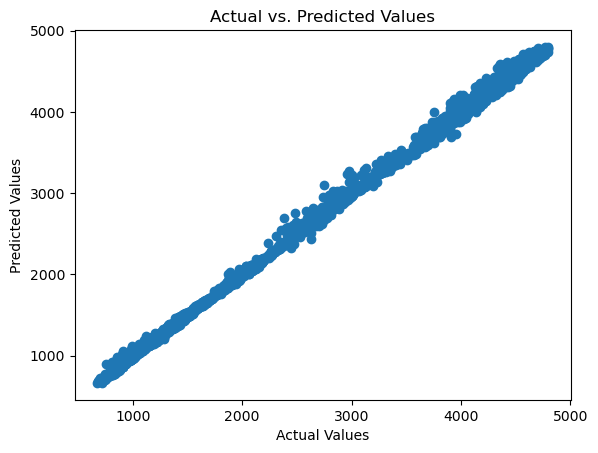

Mean Absolute Error: 21.637715436538876
Mean Squared Error: 1298.2237346987608
Root Mean Squared Error: 0.9989049781803474
R-squared: 36.030871966950244
Mean Absolute Percentage Error (MAPE): 0.010678316640863125


In [79]:
# Visualize predictions vs. actual values
plt.scatter(sp500_d_includes_results['Adj Close'], sp500_d_includes_results['Predections_LinearSVM'] )
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")
plt.show()


print("Mean Absolute Error:", dfModelScore.loc[best_model_index, 'MAE'])
print("Mean Squared Error:", dfModelScore.loc[best_model_index, 'MSE'])
print("Root Mean Squared Error:", dfModelScore.loc[best_model_index, 'RMSE'])
print("R-squared:", dfModelScore.loc[best_model_index, 'R2'])
print("Mean Absolute Percentage Error (MAPE):", dfModelScore.loc[best_model_index, 'MAPE'])

In [74]:
# Assuming df is your DataFrame containing the data
# Replace 'feature1' and 'feature2' with the names of the features you want to plot
feature1 = 'Adj Close'
feature2 = 'Predections_LinearSVM'

# Create line plot
fig = go.Figure(data=go.Scatter(
    x=sp500_d_includes_results.index,  # Assuming the index represents x-axis values
    y=sp500_d_includes_results[feature1],
    mode='lines',
    name=feature1
))

# Add another line plot for the second feature
fig.add_trace(go.Scatter(
    x=sp500_d_includes_results.index,  # Assuming the index represents x-axis values
    y=sp500_d_includes_results[feature2],
    mode='lines',
    name=feature2
))

# Customize layout
fig.update_layout(
    title='Model - log_return Vs. Predictions on train dataset - WF 200,20',
    xaxis=dict(title='X Axis'),  # Customize x-axis label
    yaxis=dict(title='Y Axis'),  # Customize y-axis label
    hovermode='closest'
)

# Show plot
fig.show()

Fourier Transform

In [ ]:
#clean the data from na values & pick the columns
fft_data = sp500.copy()
fft_data = drop_nan(fft_data)
fft_data = fft_data.loc[:, ['SMA','WMA', 'MACD', 'RSI', '%K_fast', '%D_fast', '%D_slow', 'Bollinger Diff',
                    'WPR', 'OBV', 'ROC', 'ATR', 'MFI', 'Chaikin_Oscillator', 'Adj Close']]

In [ ]:
# Calculate the Fourier Transform
data_FT = fft_data[['Adj Close']]
close_fft = np.fft.fft(np.asarray(data_FT['Adj Close'].tolist()))
fft_df = pd.DataFrame({'fft':close_fft})
fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))

# Plot the Fourier Transforms
plt.figure(figsize=(14, 7), dpi=100)
plt.plot(np.asarray(data_FT['Adj Close'].tolist()),  label='Real')
for num_ in [3, 6, 9]:
    fft_list_m10= np.copy(close_fft); fft_list_m10[num_:-num_]=0
    plt.plot(np.fft.ifft(fft_list_m10), label='Fourier transform with {} components'.format(num_))
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('S&P 500: Adj Close & Fourier transforms')
plt.legend()
plt.show()

In [ ]:
# Add technical indicators to dataset DF
# Create arima DF using predictions
#arima_df = pd.DataFrame(history, index=dataset_ex_df.index, columns=['ARIMA'])

# Set Fourier Transforms DF
fft_df.reset_index(inplace=True)
fft_df['index'] = pd.to_datetime(fft_data.index)
fft_df.set_index('index', inplace=True)
fft_df_real = pd.DataFrame(np.real(fft_df['fft']), index=fft_df.index, columns=['Fourier_real'])
fft_df_imag = pd.DataFrame(np.imag(fft_df['fft']), index=fft_df.index, columns=['Fourier_imag'])

#transform feature and lag by one
fft_df_imag = feature_transform(fft_df_imag)
fft_df_real = feature_transform(fft_df_real)
fft_df_imag = lag_technical_indicators(fft_df_imag)
fft_df_real = lag_technical_indicators(fft_df_real)

# Merge DF
merged_df = pd.concat([fft_data, fft_df_real, fft_df_imag], axis=1)
merged_df = merged_df.dropna()